In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import os
from scipy.stats import norm
from astropy.time import Time
import astropy.io.fits as fits
from astropy.table import Table

### b_HIGH filter

In [2]:
results_folder = './Images/b_HIGH/'
# Retrieve all the folder names in the results_folder (doesn't end with .fits)
folder_names = [f for f in os.listdir(results_folder) if not f.endswith('.fits')]

In [3]:
# Retrieve all the file names in the results_folder (ends with .fits)
file_names = [f for f in os.listdir(results_folder) if f.endswith('.fits')]

In [4]:
blue_ccd = 0
red_ccd = 0

blue_ccd_files = []
red_ccd_files = []

for file in file_names:
    # Obtain the header of the file
    header = fits.getheader(results_folder + file)
    if header['HIERARCH ESO DET CHIP1 NAME'] == 'EEV, EEV':
        blue_ccd += 1
        blue_ccd_files.append(file)
    elif header['HIERARCH ESO DET CHIP1 NAME'] == 'MIT/LL mosaic':
        red_ccd += 1
        red_ccd_files.append(file)

In [5]:
chip1_zp = list()
chip1_date = list()
chip2_zp = list()
chip2_date = list()

for folder in folder_names:
    if (folder + '.fits') in red_ccd_files:
        # Retrieve the date in the folder name, and convert it to MJD format
        date = folder[6:]
        # Replace the underscores with colons
        t = Time(date.replace('_', ':')).mjd
        if t > 59000:
            results_file = results_folder + folder + '/results.txt'
            data = pd.read_csv(results_file, sep=',', header=None)
            if data[1][0] == 'CHIP1':
                chip1_zp.append(data[10][0])
                chip1_date.append(t)
            elif data[1][0] == 'CHIP2':
                chip2_zp.append(data[10][0])
                chip2_date.append(t)

In [6]:
# Concatenate both lists
chip1_data = np.c_[chip1_zp, chip1_date]
chip2_data = np.c_[chip2_zp, chip2_date]

In [7]:
# Remove the tuples which contains NaN values 
chip1_data = np.asarray([t for t in chip1_data if not any(isinstance(n, float) and np.isnan(n) for n in t)])
chip2_data = np.asarray([t for t in chip2_data if not any(isinstance(n, float) and np.isnan(n) for n in t)])

In [8]:
chip1_zp = chip1_data[:,0]
chip1_date = chip1_data[:,1]
chip2_zp = chip2_data[:,0]
chip2_date = chip2_data[:,1]

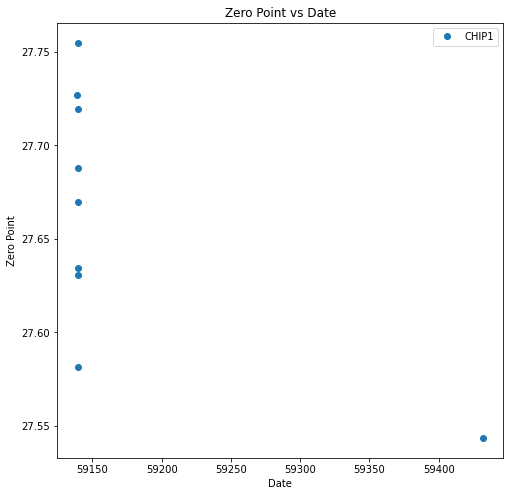

In [9]:
# Plot the data, where the X axis is the date and the Y axis is the zeropoint
plt.figure(figsize=(8,8))
plt.plot(chip1_date, chip1_zp, 'o', label='CHIP1')
#plt.plot(chip2_date, chip2_zp, 'o', label='CHIP2')
plt.xlabel('Date')
plt.ylabel('Zero Point')
plt.title('Zero Point vs Date')
plt.legend()
plt.show()

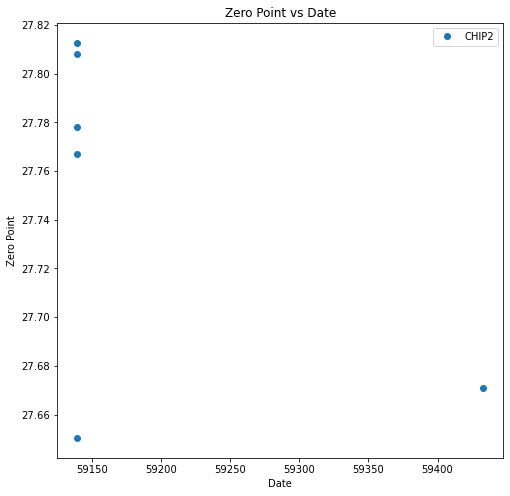

In [10]:
# Plot the data, where the X axis is the date and the Y axis is the zeropoint
#plt.plot(chip1_date, chip1_zp, 'o', label='CHIP1')
plt.figure(figsize=(8,8))
plt.plot(chip2_date, chip2_zp, 'o', label='CHIP2')
plt.xlabel('Date')
plt.ylabel('Zero Point')
plt.title('Zero Point vs Date')
plt.legend()
plt.show()

In [11]:
# Retrieve all the file names in the results_folder (ends with .fits)
file_names = [f for f in os.listdir(results_folder) if f.endswith('.fits')]
# Retrieve all the folder names in the results_folder (doesn't end with .fits)
folder_names = [f for f in os.listdir(results_folder) if not f.endswith('.fits')]

In [12]:
chip1_magnitudes = list()
chip2_magnitudes = list()

for folder in folder_names:
    if (folder + '.fits') in red_ccd_files:
        # Retrieve the date in the folder name, and convert it to MJD format
        date = folder[6:]
        # Replace the underscores with colons
        t = Time(date.replace('_', ':')).mjd
        if t > 59000:
            results_file = results_folder + folder + '/results.txt'
            magnitudes_file = results_folder + folder + '/results_faint.txt'
            data = pd.read_csv(results_file, sep=',', header=None)
            magnitudes = Table.read(magnitudes_file, delimiter=',', format='ascii')
            magnitudes = magnitudes[magnitudes['Mag_PSF_err'] < 20]
            if data[1][0] == 'CHIP1':
                magnitudes_array = list(magnitudes['Mag_PSF'])
                chip1_magnitudes.append(magnitudes_array)
            elif data[1][0] == 'CHIP2':
                magnitudes_array = list(magnitudes['Mag_PSF'])
                chip2_magnitudes.append(magnitudes_array)

In [13]:
chip1_magnitudes = [item for sublist in chip1_magnitudes for item in sublist]
chip2_magnitudes = [item for sublist in chip2_magnitudes for item in sublist]

# Transform the lists into numpy arrays
chip1_magnitudes = np.asarray(chip1_magnitudes)
chip2_magnitudes = np.asarray(chip2_magnitudes)

# Filter the NaN values of the arrays
chip1_magnitudes = chip1_magnitudes[~np.isnan(chip1_magnitudes)]
chip2_magnitudes = chip2_magnitudes[~np.isnan(chip2_magnitudes)]

In [14]:
chip1_magnitudes = chip1_magnitudes[chip1_magnitudes < 35]
chip2_magnitudes = chip2_magnitudes[chip2_magnitudes < 35]

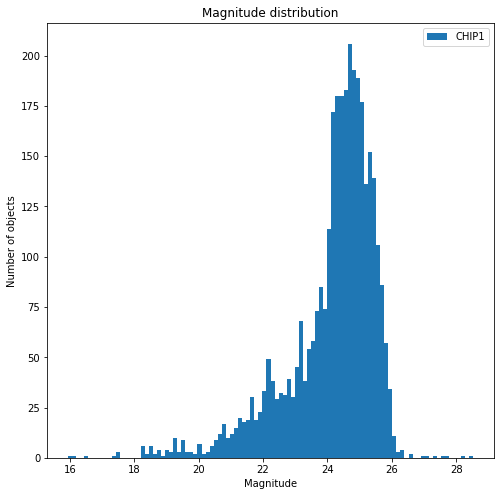

In [15]:
# Plot the chip1 and chip2 magnitudes as separate histograms
plt.figure(figsize=(8,8))
plt.hist(chip1_magnitudes, bins=100, label='CHIP1')
plt.xlabel('Magnitude')
plt.ylabel('Number of objects')
plt.title('Magnitude distribution')
plt.legend()
plt.show()

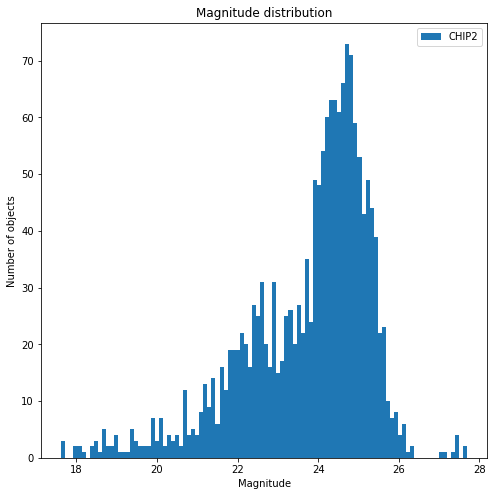

In [16]:
# Plot the chip1 and chip2 magnitudes as separate histograms
plt.figure(figsize=(8,8))
plt.hist(chip2_magnitudes, bins=100, label='CHIP2')
plt.xlabel('Magnitude')
plt.ylabel('Number of objects')
plt.title('Magnitude distribution')
plt.legend()
plt.show()

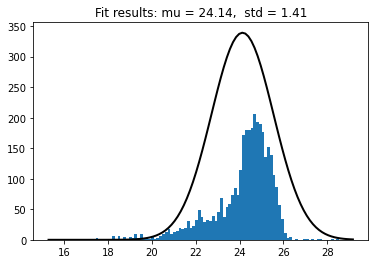

In [17]:
# Fit a Gaussian to the CHIP1 data
mean, std = norm.fit(chip1_magnitudes)

plt.hist(chip1_magnitudes, bins=100, label='CHIP1')
# Plot the PDF
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean, std)
plt.plot(x, 1200*p, 'k', linewidth=2)
# Label the plot
title = "Fit results: mu = %.2f,  std = %.2f" % (mean, std)
plt.title(title)
plt.show()

### v_HIGH filter

In [18]:
results_folder = './Images/v_HIGH/'
# Retrieve all the folder names in the results_folder (doesn't end with .fits)
folder_names = [f for f in os.listdir(results_folder) if not f.endswith('.fits')]

In [19]:
# Retrieve all the file names in the results_folder (ends with .fits)
file_names = [f for f in os.listdir(results_folder) if f.endswith('.fits')]

In [20]:
blue_ccd = 0
red_ccd = 0

blue_ccd_files = []
red_ccd_files = []

for file in file_names:
    # Obtain the header of the file
    header = fits.getheader(results_folder + file)
    if header['HIERARCH ESO DET CHIP1 NAME'] == 'EEV, EEV':
        blue_ccd += 1
        blue_ccd_files.append(file)
    elif header['HIERARCH ESO DET CHIP1 NAME'] == 'MIT/LL mosaic':
        red_ccd += 1
        red_ccd_files.append(file)

In [21]:
print('Number of blue ccd files: ' + str(blue_ccd))
print('Number of red ccd files: ' + str(red_ccd))

Number of blue ccd files: 8
Number of red ccd files: 44


In [22]:
chip1_zp = list()
chip1_date = list()
chip2_zp = list()
chip2_date = list()

for folder in folder_names:
    if (folder + '.fits') in red_ccd_files:
        # Retrieve the date in the folder name, and convert it to MJD format
        date = folder[6:]
        # Replace the underscores with colons
        t = Time(date.replace('_', ':')).mjd
        #if t > 59000:
        results_file = results_folder + folder + '/results.txt'
        data = pd.read_csv(results_file, sep=',', header=None)
        if data[1][0] == 'CHIP1':
            chip1_zp.append(data[10][0])
            chip1_date.append(t)
        elif data[1][0] == 'CHIP2':
            chip2_zp.append(data[10][0])
            chip2_date.append(t)

In [23]:
# Concatenate both lists
chip1_data = np.c_[chip1_zp, chip1_date]
chip2_data = np.c_[chip2_zp, chip2_date]

# Remove the tuples which contains NaN values 
chip1_data = np.asarray([t for t in chip1_data if not any(isinstance(n, float) and np.isnan(n) for n in t)])
chip2_data = np.asarray([t for t in chip2_data if not any(isinstance(n, float) and np.isnan(n) for n in t)])

chip1_zp = chip1_data[:,0]
chip1_date = chip1_data[:,1]
chip2_zp = chip2_data[:,0]
chip2_date = chip2_data[:,1]

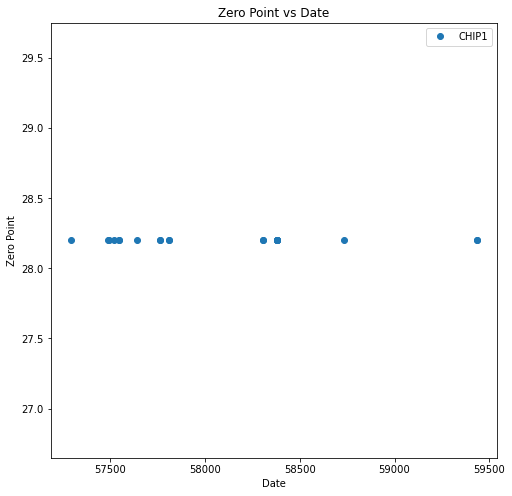

In [24]:
# Plot the data, where the X axis is the date and the Y axis is the zeropoint
plt.figure(figsize=(8,8))
plt.plot(chip1_date, chip1_zp, 'o', label='CHIP1')
#plt.plot(chip2_date, chip2_zp, 'o', label='CHIP2')
plt.xlabel('Date')
plt.ylabel('Zero Point')
plt.title('Zero Point vs Date')
plt.legend()
plt.show()

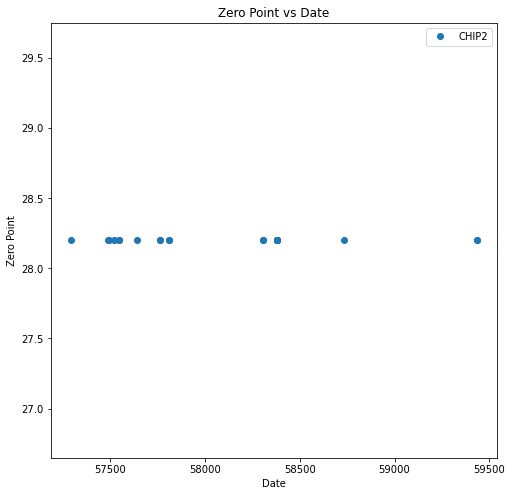

In [25]:
# Plot the data, where the X axis is the date and the Y axis is the zeropoint
plt.figure(figsize=(8,8))
#plt.plot(chip1_date, chip1_zp, 'o', label='CHIP1')
plt.plot(chip2_date, chip2_zp, 'o', label='CHIP2')
plt.xlabel('Date')
plt.ylabel('Zero Point')
plt.title('Zero Point vs Date')
plt.legend()
plt.show()

In [26]:
# Retrieve all the file names in the results_folder (ends with .fits)
file_names = [f for f in os.listdir(results_folder) if f.endswith('.fits')]
# Retrieve all the folder names in the results_folder (doesn't end with .fits)
folder_names = [f for f in os.listdir(results_folder) if not f.endswith('.fits')]

In [27]:
chip1_magnitudes = list()
chip2_magnitudes = list()

for folder in folder_names:
    if (folder + '.fits') in red_ccd_files:
        # Retrieve the date in the folder name, and convert it to MJD format
        date = folder[6:]
        # Replace the underscores with colons
        t = Time(date.replace('_', ':')).mjd
        #if t > 59000:
        results_file = results_folder + folder + '/results.txt'
        magnitudes_file = results_folder + folder + '/results_faint.txt'
        data = pd.read_csv(results_file, sep=',', header=None)
        magnitudes = Table.read(magnitudes_file, delimiter=',', format='ascii')
        magnitudes = magnitudes[magnitudes['Mag_PSF_err'] < 10]
        if data[1][0] == 'CHIP1':
            magnitudes_array = list(magnitudes['Mag_PSF'])
            chip1_magnitudes.append(magnitudes_array)
        elif data[1][0] == 'CHIP2':
            magnitudes_array = list(magnitudes['Mag_PSF'])
            chip2_magnitudes.append(magnitudes_array)

In [28]:
chip1_magnitudes = [item for sublist in chip1_magnitudes for item in sublist]
chip2_magnitudes = [item for sublist in chip2_magnitudes for item in sublist]

# Transform the lists into numpy arrays
chip1_magnitudes = np.asarray(chip1_magnitudes)
chip2_magnitudes = np.asarray(chip2_magnitudes)

# Filter the NaN values of the arrays
chip1_magnitudes = chip1_magnitudes[~np.isnan(chip1_magnitudes)]
chip2_magnitudes = chip2_magnitudes[~np.isnan(chip2_magnitudes)]

chip1_magnitudes = chip1_magnitudes[chip1_magnitudes < 35]
chip2_magnitudes = chip2_magnitudes[chip2_magnitudes < 35]

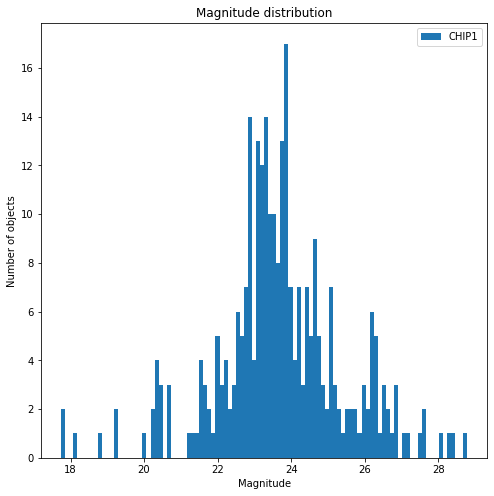

In [29]:
# Plot the chip1 and chip2 magnitudes as separate histograms
plt.figure(figsize=(8,8))
plt.hist(chip1_magnitudes, bins=100, label='CHIP1')
plt.xlabel('Magnitude')
plt.ylabel('Number of objects')
plt.title('Magnitude distribution')
plt.legend()
plt.show()

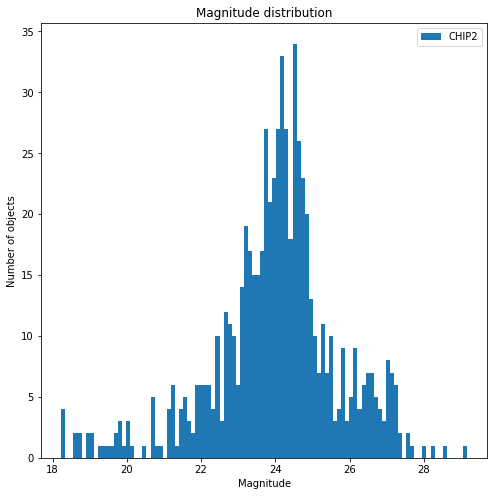

In [30]:
# Plot the chip1 and chip2 magnitudes as separate histograms
plt.figure(figsize=(8,8))
plt.hist(chip2_magnitudes, bins=100, label='CHIP2')
plt.xlabel('Magnitude')
plt.ylabel('Number of objects')
plt.title('Magnitude distribution')
plt.legend()
plt.show()

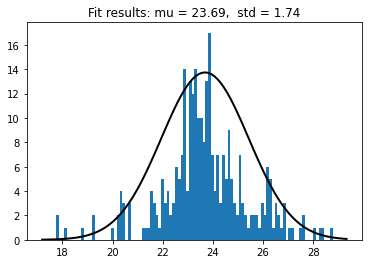

In [31]:
# Fit a Gaussian to the CHIP1 data
mean, std = norm.fit(chip1_magnitudes)

plt.hist(chip1_magnitudes, bins=100, label='CHIP1')
# Plot the PDF
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean, std)
plt.plot(x, 60*p, 'k', linewidth=2)
# Label the plot
title = "Fit results: mu = %.2f,  std = %.2f" % (mean, std)
plt.title(title)
plt.show()

### R_SPECIAL filter

In [32]:
results_folder = './Images/R_SPECIAL/'
# Retrieve all the folder names in the results_folder (doesn't end with .fits)
folder_names = [f for f in os.listdir(results_folder) if not f.endswith('.fits')]

# Retrieve all the file names in the results_folder (ends with .fits)
file_names = [f for f in os.listdir(results_folder) if f.endswith('.fits')]

In [33]:
blue_ccd = 0
red_ccd = 0

blue_ccd_files = []
red_ccd_files = []

for file in file_names:
    # Obtain the header of the file
    header = fits.getheader(results_folder + file)
    if header['HIERARCH ESO DET CHIP1 NAME'] == 'EEV, EEV':
        blue_ccd += 1
        blue_ccd_files.append(file)
    elif header['HIERARCH ESO DET CHIP1 NAME'] == 'MIT/LL mosaic':
        red_ccd += 1
        red_ccd_files.append(file)

In [34]:
print('Number of blue ccd files: ' + str(blue_ccd))
print('Number of red ccd files: ' + str(red_ccd))

Number of blue ccd files: 24
Number of red ccd files: 927


In [49]:
chip1_zp = list()
chip1_date = list()
chip2_zp = list()
chip2_date = list()

for folder in folder_names:
    if (folder + '.fits') in red_ccd_files:
        # Retrieve the date in the folder name, and convert it to MJD format
        date = folder[6:]
        # Replace the underscores with colons
        t = Time(date.replace('_', ':')).mjd
        results_file = results_folder + folder + '/results.txt'
        data = pd.read_csv(results_file, sep=',', header=None)
        if data[1][0] == 'CHIP1':
            chip1_zp.append(data[10][0])
            chip1_date.append(t)
        elif data[1][0] == 'CHIP2':
            chip2_zp.append(data[10][0])
            chip2_date.append(t)

In [50]:
# Concatenate both lists
chip1_data = np.c_[chip1_zp, chip1_date]
chip2_data = np.c_[chip2_zp, chip2_date]

# Remove the tuples which contains NaN values 
chip1_data = np.asarray([t for t in chip1_data if not any(isinstance(n, float) and np.isnan(n) for n in t)])
chip2_data = np.asarray([t for t in chip2_data if not any(isinstance(n, float) and np.isnan(n) for n in t)])

chip1_zp = chip1_data[:,0]
chip1_date = chip1_data[:,1]
chip2_zp = chip2_data[:,0]
chip2_date = chip2_data[:,1]

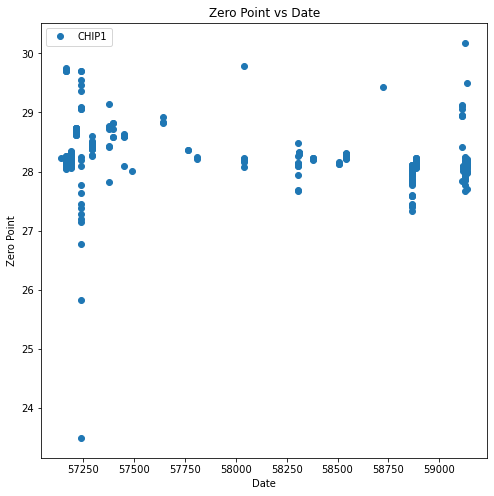

In [51]:
# Plot the data, where the X axis is the date and the Y axis is the zeropoint
plt.figure(figsize=(8,8))
plt.plot(chip1_date, chip1_zp, 'o', label='CHIP1')
#plt.plot(chip2_date, chip2_zp, 'o', label='CHIP2')
plt.xlabel('Date')
plt.ylabel('Zero Point')
plt.title('Zero Point vs Date')
plt.legend()
plt.show()

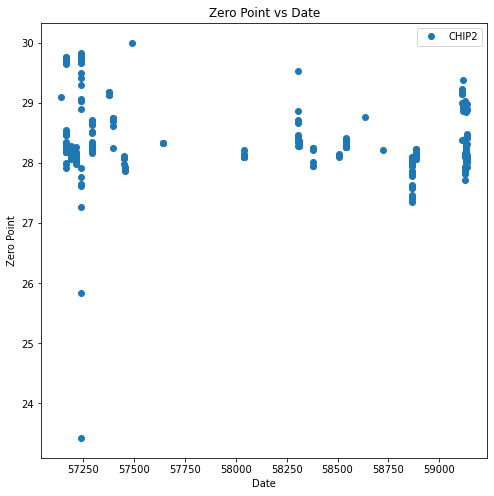

In [52]:
# Plot the data, where the X axis is the date and the Y axis is the zeropoint
plt.figure(figsize=(8,8))
#plt.plot(chip1_date, chip1_zp, 'o', label='CHIP1')
plt.plot(chip2_date, chip2_zp, 'o', label='CHIP2')
plt.xlabel('Date')
plt.ylabel('Zero Point')
plt.title('Zero Point vs Date')
plt.legend()
plt.show()

In [39]:
# Retrieve all the file names in the results_folder (ends with .fits)
file_names = [f for f in os.listdir(results_folder) if f.endswith('.fits')]
# Retrieve all the folder names in the results_folder (doesn't end with .fits)
folder_names = [f for f in os.listdir(results_folder) if not f.endswith('.fits')]

In [53]:
chip1_magnitudes = list()
chip2_magnitudes = list()

for folder in folder_names:
    if (folder + '.fits') in red_ccd_files:
        # Retrieve the date in the folder name, and convert it to MJD format
        date = folder[6:]
        # Replace the underscores with colons
        t = Time(date.replace('_', ':')).mjd
        if t > 59000:
            results_file = results_folder + folder + '/results.txt'
            magnitudes_file = results_folder + folder + '/results_faint.txt'
            data = pd.read_csv(results_file, sep=',', header=None)
            magnitudes = Table.read(magnitudes_file, delimiter=',', format='ascii')
            magnitudes = magnitudes[magnitudes['Mag_PSF_err'] < 10]
            if data[1][0] == 'CHIP1':
                magnitudes_array = list(magnitudes['Mag_PSF'])
                chip1_magnitudes.append(magnitudes_array)
            elif data[1][0] == 'CHIP2':
                magnitudes_array = list(magnitudes['Mag_PSF'])
                chip2_magnitudes.append(magnitudes_array)

In [54]:
chip1_magnitudes = [item for sublist in chip1_magnitudes for item in sublist]
chip2_magnitudes = [item for sublist in chip2_magnitudes for item in sublist]

# Transform the lists into numpy arrays
chip1_magnitudes = np.asarray(chip1_magnitudes)
chip2_magnitudes = np.asarray(chip2_magnitudes)

# Filter the NaN values of the arrays
chip1_magnitudes = chip1_magnitudes[~np.isnan(chip1_magnitudes)]
chip2_magnitudes = chip2_magnitudes[~np.isnan(chip2_magnitudes)]

chip1_magnitudes = chip1_magnitudes[chip1_magnitudes < 35]
chip2_magnitudes = chip2_magnitudes[chip2_magnitudes < 35]

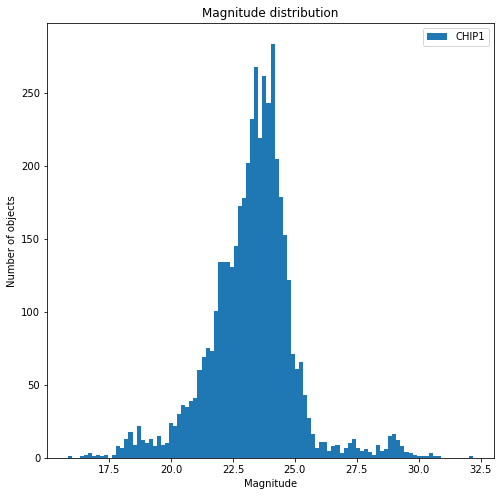

In [55]:
# Plot the chip1 and chip2 magnitudes as separate histograms
plt.figure(figsize=(8,8))
plt.hist(chip1_magnitudes, bins=100, label='CHIP1')
plt.xlabel('Magnitude')
plt.ylabel('Number of objects')
plt.title('Magnitude distribution')
plt.legend()
plt.show()

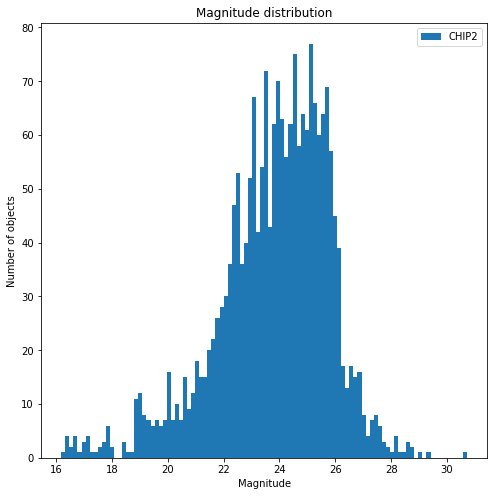

In [56]:
# Plot the chip1 and chip2 magnitudes as separate histograms
plt.figure(figsize=(8,8))
plt.hist(chip2_magnitudes, bins=100, label='CHIP2')
plt.xlabel('Magnitude')
plt.ylabel('Number of objects')
plt.title('Magnitude distribution')
plt.legend()
plt.show()

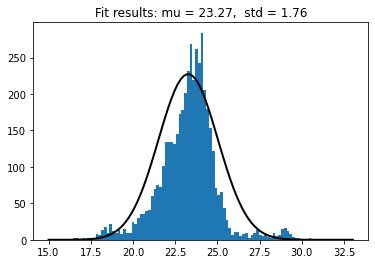

In [58]:
# Fit a Gaussian to the CHIP1 data
mean, std = norm.fit(chip1_magnitudes)

plt.hist(chip1_magnitudes, bins=100, label='CHIP1')
# Plot the PDF
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean, std)
plt.plot(x, 1000*p, 'k', linewidth=2)
# Label the plot
title = "Fit results: mu = %.2f,  std = %.2f" % (mean, std)
plt.title(title)
plt.show()